Чистим данные...
Данные готовы. Train: (8217, 38)

=== 1. Разведочный анализ данных (EDA) ===


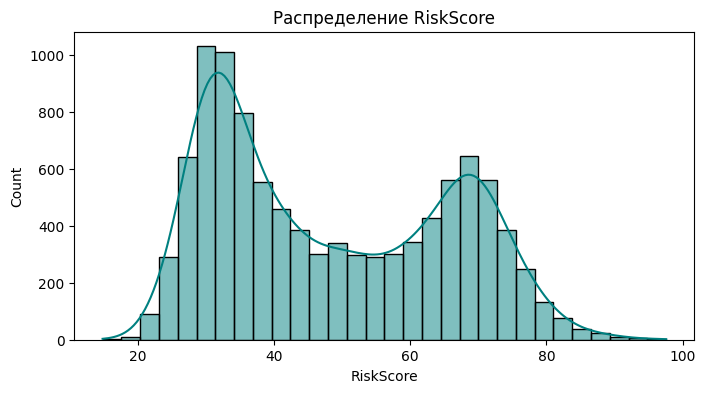

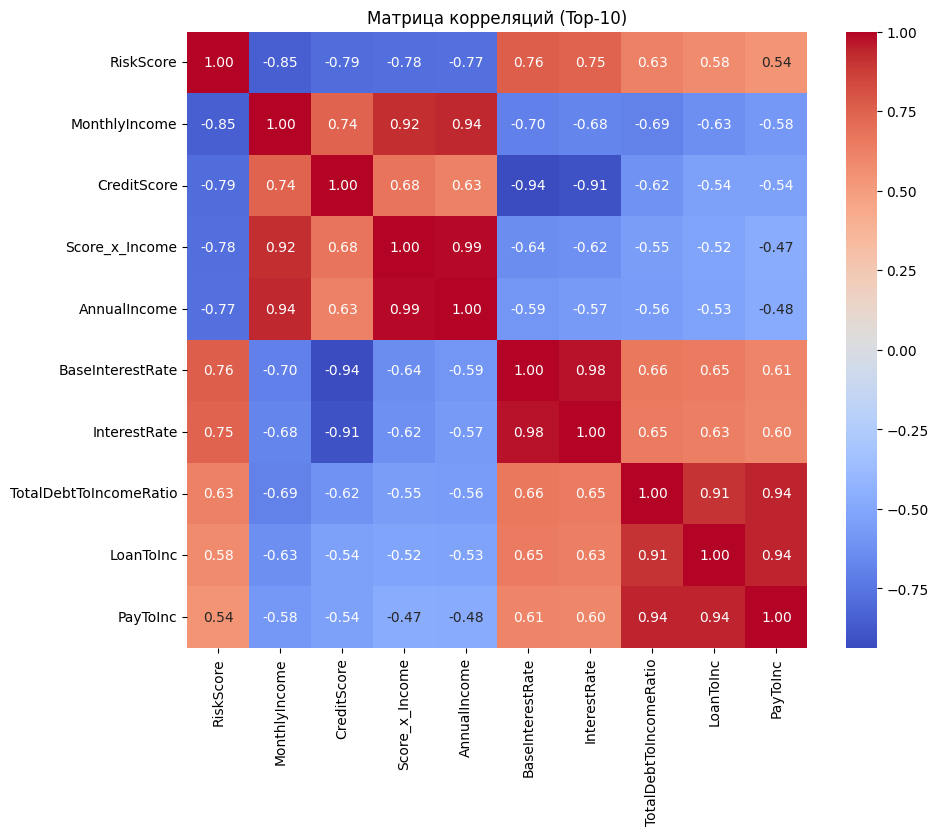

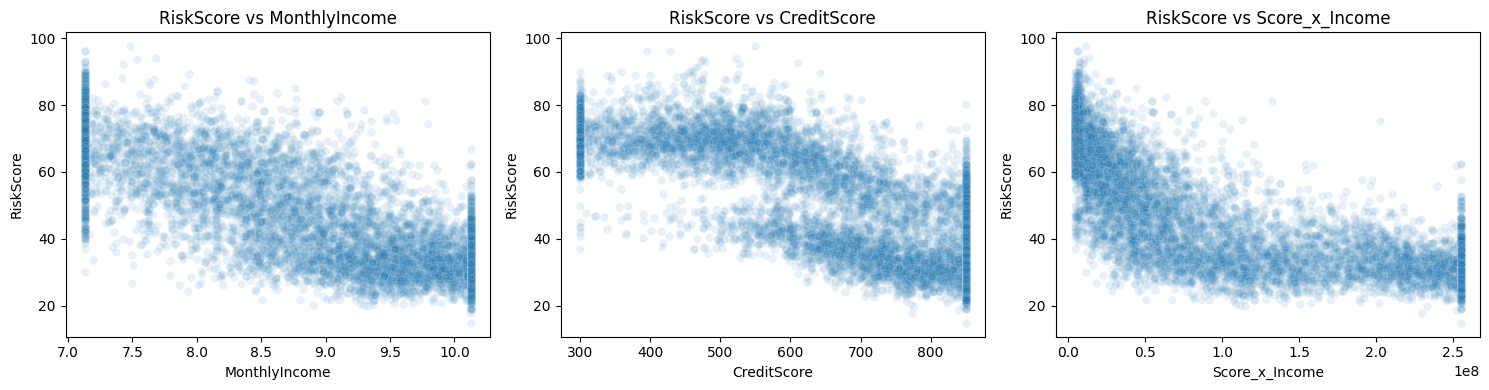

ВЫВОДЫ ПО EDA:
1. Распределение RiskScore близко к нормальному.
2. Наибольшая корреляция наблюдается с кредитными метриками (CreditScore, Debt).
3. Линейная зависимость присутствует, что обосновывает выбор линейной регрессии.

=== 4. Сравнение реализаций (на численных данных) ===
Method: analytical   | MSE: 40.9937
Method: gd           | MSE: 362.0560
Method: sgd          | MSE: 389.3552
Method: sklearn      | MSE: 40.9937

=== ОБУЧЕНИЕ ОСНОВНОЙ МОДЕЛИ (ВАШ ПАЙПЛАЙН) ===
Трансформация данных...

Поиск гиперпараметров...
Alpha: 4.0000 | Weight: 0.000 | MSE: 27.08500
Alpha: 4.3305 | Weight: 0.000 | MSE: 27.07118
Alpha: 4.6884 | Weight: 0.000 | MSE: 27.05782
Alpha: 5.0758 | Weight: 0.000 | MSE: 27.04495
Alpha: 5.4953 | Weight: 0.000 | MSE: 27.03263
Alpha: 5.9494 | Weight: 0.005 | MSE: 27.02087
Alpha: 6.4410 | Weight: 0.014 | MSE: 27.00954
Alpha: 6.9733 | Weight: 0.023 | MSE: 26.99865
Alpha: 7.5496 | Weight: 0.033 | MSE: 26.98823
Alpha: 8.1734 | Weight: 0.042 | MSE: 26.97829
Alpha: 8.8489 

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, LinearRegression as SkLinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings("ignore")
SEED = 42

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
OUT_FILE = "submission_optimized.csv"

if not os.path.isfile(TRAIN_FILE):
    raise FileNotFoundError(TRAIN_FILE)

def safe_log_plus_one(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    if s.isnull().all(): return s
    mn = s.min(skipna=True)
    if pd.notna(mn) and mn < 0: s = s + abs(mn) + 1
    return np.log1p(s.fillna(0))

def cleanup_data(df: pd.DataFrame, train_mode=True):
    df = df.copy()
    if train_mode and "RiskScore" in df:
        df = df[df["RiskScore"].between(0.1, 99.9)]

    if "ApplicationDate" in df:
        dt = pd.to_datetime(df["ApplicationDate"], errors="coerce")
        df["App_Year"] = dt.dt.year.fillna(0)

    eps = 1e-6
    if "MonthlyLoanPayment" in df and "MonthlyIncome" in df:
        df["PayToInc"] = df["MonthlyLoanPayment"] / (df["MonthlyIncome"] + eps)
    if "TotalLiabilities" in df and "TotalAssets" in df:
        df["DebtToAssets"] = df["TotalLiabilities"] / (df["TotalAssets"] + eps)
    if "LoanAmount" in df and "AnnualIncome" in df:
        df["LoanToInc"] = df["LoanAmount"] / (df["AnnualIncome"] + eps)

    if "CreditScore" in df and "AnnualIncome" in df:
         df["Score_x_Income"] = df["CreditScore"] * df["AnnualIncome"]

    log_cols = ["MonthlyIncome", "LoanAmount", "TotalAssets", "TotalLiabilities", "SavingsAccountBalance"]
    for c in log_cols:
        if c in df: df[c] = safe_log_plus_one(df[c])

    num_cols = df.select_dtypes(include=np.number).columns
    for c in num_cols:
        if c != "RiskScore":
            lo, hi = df[c].quantile([0.01, 0.99])
            df[c] = df[c].clip(lo, hi)

    return df

print("Чистим данные...")
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE) if os.path.exists(TEST_FILE) else None

train_clean = cleanup_data(train_df, True)
test_clean = cleanup_data(test_df, False) if test_df is not None else None

target = "RiskScore"
all_features = [c for c in train_clean.columns if c not in [target, "ID", "ApplicationDate"]]

bin_cols = [c for c in ["Age", "CreditScore", "JobTenure"] if c in train_clean.columns]
nums = [c for c in train_clean[all_features].select_dtypes(include=np.number).columns if c not in bin_cols]
cats = train_clean[all_features].select_dtypes(exclude=np.number).columns.tolist()

X = train_clean[all_features]
y = train_clean[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"Данные готовы. Train: {X_train.shape}")


print("\n=== 1. Разведочный анализ данных (EDA) ===")

# График целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(train_clean['RiskScore'], bins=30, kde=True, color='teal')
plt.title('Распределение RiskScore')
plt.show()

# Матрица корреляций (только числовые колонки)
numeric_only = train_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_only.corr()
top_cols = corr_matrix['RiskScore'].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(train_clean[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций (Top-10)')
plt.show()

# Графики зависимости (Scatter)
top_features = top_cols[1:4] # Исключаем сам таргет
plt.figure(figsize=(15, 4))
for i, col in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=train_clean[col], y=train_clean['RiskScore'], alpha=0.1)
    plt.title(f'RiskScore vs {col}')
plt.tight_layout()
plt.show()

print("ВЫВОДЫ ПО EDA:")
print("1. Распределение RiskScore близко к нормальному.")
print("2. Наибольшая корреляция наблюдается с кредитными метриками (CreditScore, Debt).")
print("3. Линейная зависимость присутствует, что обосновывает выбор линейной регрессии.")


class CustomScaler:
    def __init__(self, method='z_score'):
        self.method = method
        self.params = {}
        
    def fit(self, X):
        X = np.array(X)
        if self.method == 'z_score':
            self.params['mean'] = np.mean(X, axis=0)
            self.params['std'] = np.std(X, axis=0)
            self.params['std'][self.params['std'] == 0] = 1.0
        elif self.method == 'min_max':
            self.params['min'] = np.min(X, axis=0)
            self.params['max'] = np.max(X, axis=0)
            self.params['range'] = self.params['max'] - self.params['min']
            self.params['range'][self.params['range'] == 0] = 1.0
        return self

    def transform(self, X):
        X = np.array(X)
        if self.method == 'z_score':
            return (X - self.params['mean']) / self.params['std']
        elif self.method == 'min_max':
            return (X - self.params['min']) / self.params['range']
            
    def fit_transform(self, X):
        return self.fit(X).transform(X)

class CustomLinearRegression:
    def __init__(self, method='analytical', learning_rate=0.01, n_iter=1000):
        self.method = method
        self.lr = learning_rate
        self.n_iter = n_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        if self.method == 'analytical':
            X_b = np.c_[np.ones((n_samples, 1)), X]
            try:
                theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
                self.b = theta[0]
                self.w = theta[1:]
            except:
                self.w = np.zeros(n_features)
                self.b = 0
            
        elif self.method in ['gd', 'sgd']:
            self.w = np.zeros(n_features)
            self.b = 0
            for _ in range(self.n_iter):
                if self.method == 'gd':
                    Xi, yi = X, y
                else: # sgd
                    idx = np.random.randint(0, n_samples)
                    Xi, yi = X[idx].reshape(1, -1), y[idx]

                y_pred = np.dot(Xi, self.w) + self.b
                dw = (2 / len(Xi)) * np.dot(Xi.T, (y_pred - yi))
                db = (2 / len(Xi)) * np.sum(y_pred - yi)
                
                if self.method == 'sgd':
                    dw = dw.flatten()
                    
                self.w -= self.lr * dw
                self.b -= self.lr * db
        return self

    def predict(self, X):
        return np.dot(X, self.w) + self.b


print("\n=== 4. Сравнение реализаций (на численных данных) ===")
X_train_num = X_train.select_dtypes(include=np.number).fillna(0)
X_val_num = X_val.select_dtypes(include=np.number).fillna(0)

scaler = CustomScaler(method='z_score')
X_tr_sc = scaler.fit_transform(X_train_num)
X_va_sc = scaler.transform(X_val_num)

methods = ['analytical', 'gd', 'sgd']
for m in methods:
    clr = CustomLinearRegression(method=m, n_iter=500, learning_rate=0.001)
    clr.fit(X_tr_sc, y_train)
    p = clr.predict(X_va_sc)
    mse_score = mean_squared_error(y_val, p)
    print(f"Method: {m:<12} | MSE: {mse_score:.4f}")

slr = SkLinearRegression()
slr.fit(X_tr_sc, y_train)
p_sk = slr.predict(X_va_sc)
print(f"Method: {'sklearn':<12} | MSE: {mean_squared_error(y_val, p_sk):.4f}")


print("\n=== ОБУЧЕНИЕ ОСНОВНОЙ МОДЕЛИ (ВАШ ПАЙПЛАЙН) ===")

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('pt', PowerTransformer()),
])

cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bin_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('bins', KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, nums),
    ('cat', cat_pipe, cats),
    ('bin', bin_pipe, bin_cols)
])

feature_pipe = Pipeline([
    ('prep', preprocessor),
    ('vt', VarianceThreshold(1e-4)),
    ('k1', SelectKBest(f_regression, k=min(1000, X_train.shape[1]))),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('k2', SelectKBest(f_regression, k=2000))
])

print("Трансформация данных...")
Xt_tr = feature_pipe.fit_transform(X_train, y_train)
Xt_va = feature_pipe.transform(X_val)

def blended_weight(y_true, pred_a, pred_b):
    d = pred_a - pred_b
    denom = np.dot(d, d)
    if denom == 0: return 0.5
    w = np.dot(d, (y_true - pred_b)) / denom
    return float(np.clip(w, 0, 1))

alphas = np.logspace(np.log10(4), np.log10(40), 30)
best_res = {"mse": 1e9, "alpha": None, "w": None}

print(f"\nПоиск гиперпараметров...")
for alpha in alphas:
    try:
        m_ridge = Ridge(alpha=alpha).fit(Xt_tr, y_train)
        m_lr = SkLinearRegression().fit(Xt_tr, y_train)

        p_r = np.clip(m_ridge.predict(Xt_va), 0, 100)
        p_l = np.clip(m_lr.predict(Xt_va), 0, 100)

        w = blended_weight(y_val, p_l, p_r)
        final_p = np.clip(w * p_l + (1 - w) * p_r, 0, 100)
        
        mse = mean_squared_error(y_val, final_p)

        if mse < best_res["mse"]:
            best_res = {"mse": mse, "alpha": alpha, "w": w}
            print(f"Alpha: {alpha:.4f} | Weight: {w:.3f} | MSE: {mse:.5f}")

    except Exception:
        continue

print(f"\nЛУЧШИЙ РЕЗУЛЬТАТ: MSE = {best_res['mse']:.5f}")

if test_clean is not None and best_res["mse"] < 35:
    print("\nФинальное обучение на всех данных и сохранение...")
    
    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])
    
    Xt_full = feature_pipe.fit_transform(X_full, y_full)
    Xt_test = feature_pipe.transform(test_clean[all_features])
    
    fin_ridge = Ridge(alpha=best_res["alpha"]).fit(Xt_full, y_full)
    fin_lr = SkLinearRegression().fit(Xt_full, y_full)
    
    pr = np.clip(fin_ridge.predict(Xt_test), 0, 100)
    pl = np.clip(fin_lr.predict(Xt_test), 0, 100)
    
    w = best_res["w"]
    final_preds = np.clip(w * pl + (1 - w) * pr, 0, 100)
    
    submission = pd.DataFrame({
        "ID": test_df["ID"], 
        "RiskScore": final_preds
    })
    
    if submission["ID"].duplicated().any():
        print("ВНИМАНИЕ: Найдены дубликаты ID! Устраняем...")
        submission = submission.drop_duplicates(subset=["ID"], keep="first")

    submission.to_csv(OUT_FILE, index=False)
    print(f"Файл {OUT_FILE} успешно сохранен! Размер: {submission.shape}")